#Imports and setup

In [ ]:
#imports

#div
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import itertools
import seaborn
import cv2   #openCV


#sklearn
from sklearn.datasets import load_diabetes
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, classification_report
from sklearn.linear_model import LogisticRegression, LinearRegression, SGDClassifier
from sklearn.cluster import KMeans
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import chi2, SelectKBest, f_regression
from sklearn.svm import SVC
from sklearn.datasets import load_digits

#tensorflow
from tensorflow.python.keras.layers import Dense, InputLayer
from tensorflow.python.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model

#keras
from keras.optimizers import SGD
from keras.models import Sequential, Model
from keras.layers import Input, Dense

In [ ]:
#load dataset
data = load_diabetes()
x, y = data['data'], data['target']

In [ ]:
#print some info retrieved from dataset
#Lists all the various features in the dataset (column names)
print('List of features:',data["feature_names"])

List of features: ['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']


#Splitting and standarization

We now have to split our data into two groups, one for testing and one for training.

In addition to this we will also have to standarize the dataset. This to get the correct range (0, 1) and not (-1, 1).

In [ ]:
#Define the default variables
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

Converting to classification

In [ ]:
#To convert into classification, could also create into it's own separate helper function.
#Takes the input array containing zeros.
#If the element is larger than 140 the value of the element in the array will be set to 1, else 0.
y_conv = np.zeros(y.shape)
y_conv[y > 140] = 1.
y_conv = y_conv.astype(int) #Sets to integer datatype.

def class_cnv(target, threshold):
    result = np.zeros(len(target))
    for i in range(len(target)):
        if target >= threshold:
            result[i] = 1
    return result

In [ ]:
#To split the data into two sets, one for training and other for testing.
#Ratio for now is 80/20, 80% going to training, rest to testing
x_train_split, x_test_split, y_train_split, y_test_split = train_test_split(x, y_conv, test_size=0.2, random_state=42, stratify=y_conv)

In [ ]:
#To achieve the correct scaling we have to standarize the dataset so that the range is 0 to 1, and not -1 to 1). 
min_max_scaler = MinMaxScaler(feature_range=(0,1))
x_train_split_standarized = min_max_scaler.fit_transform(x_train_split)
x_test_split_standarized  = min_max_scaler.fit_transform(x_test_split)

#Training & plots


In [ ]:
def feature_selection(train_data, y_data, test_data, n_features='all', regression=True):
    score_function = f_regression
    if (regression):
        score_function = chi2


    kbest = SelectKBest(score_func=score_function, k=n_features)
    kbest.fit(train_data, y_data)
    
    x_train_kbest = kbest.transform(train_data)
    x_test_kbest = kbest.transform(test_data)

    return x_train_kbest, x_test_kbest, kbest

In [ ]:
def plot_kbest(scores):
    plt.bar([i for i in range(len(scores))], scores)
    plt.title('Score value of each feature')
    plt.xlabel('Feature')
    plt.ylabel('Score')
    plt.show()

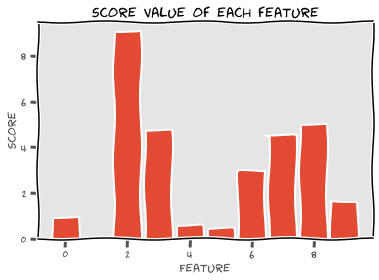

In [ ]:


x_train_features = x_train_split_standarized
y_train_features = y_train_split
x_test_features = x_test_split_standarized

x_train_kbest, x_test_kbest, kbest = feature_selection(x_train_features, y_train_features, x_test_features)
plot_kbest(kbest.scores_)


#ANN

In [ ]:
x_train = x_train_kbest
x_test = x_test_kbest
y_train = y_train_split
y_test = y_test_split

In [ ]:
predicter = Sequential()

#predicter.add(Dense(units=features*2, activation='relu', input_dim=features, name='Input'))
predicter.add(Dense(units=10, activation='relu', name='Hidden1'))
predicter.add(Dense(units=5, activation='relu', name='Hidden2'))
predicter.add(Dense(units=1, activation='sigmoid', name='Output'))
predicter.compile(optimizer='nadam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
trained_data = predicter.fit(x = x_train, y = y_train, epochs=200, batch_size=64, shuffle=True, validation_data=(x_test, y_test), verbose=1)

Epoch 1/200
6/6 [==============================] - 0s 22ms/step - loss: 0.6755 - accuracy: 0.5977 - val_loss: 0.6675 - val_accuracy: 0.5618
Epoch 2/200
6/6 [==============================] - 0s 4ms/step - loss: 0.6732 - accuracy: 0.5977 - val_loss: 0.6652 - val_accuracy: 0.5843
Epoch 3/200
6/6 [==============================] - 0s 4ms/step - loss: 0.6706 - accuracy: 0.6091 - val_loss: 0.6628 - val_accuracy: 0.6067
Epoch 4/200
6/6 [==============================] - 0s 5ms/step - loss: 0.6681 - accuracy: 0.6062 - val_loss: 0.6602 - val_accuracy: 0.6292
Epoch 5/200
6/6 [==============================] - 0s 4ms/step - loss: 0.6658 - accuracy: 0.6006 - val_loss: 0.6578 - val_accuracy: 0.6404
Epoch 6/200
6/6 [==============================] - 0s 4ms/step - loss: 0.6638 - accuracy: 0.6006 - val_loss: 0.6554 - val_accuracy: 0.6517
Epoch 7/200
6/6 [==============================] - 0s 4ms/step - loss: 0.6617 - accuracy: 0.6034 - val_loss: 0.6529 - val_accuracy: 0.6404
Epoch 8/200
6/6 [=========

In [ ]:
#plotter for confusion matrix visualisation
def result_matrix(matrix_name, matrix_data):
    #Set colors
    colormap = ListedColormap(['white, green, white, green'])

    #Setup plot itself
    plt.figure()
    plt.matshow(matrix_data)
    for i in range(matrix_data.shape[0]):
        for j in range(matrix_data.shape[1]):
            plt.text(x=j, y=i, s=matrix_data[i,j], va='center', ha='center')
    
    #Show plot
    plt.title(matrix_name)
    plt.xlabel('Predicted result')
    plt.ylabel('Real result')
    plt.show()

Ranging from 0 to 1


[0.9865395  0.25721347 0.07553843 0.5452885  0.7205864  0.644681
 0.12384665 0.41319472 0.802073   0.07544389 0.06467184 0.19509277
 0.82367045 0.7734399  0.64962214 0.0459643  0.9709698  0.1763753
 0.07659182 0.5852673  0.10765299 0.1154882  0.09809238 0.8114289
 0.66626287 0.20038286 0.3648213  0.03702858 0.05088681 0.15286806
 0.59819365 0.77540696 0.58680093 0.63889295 0.924112   0.6201937
 0.8007068  0.19481266 0.19617647 0.5555602  0.9698055  0.4898584
 0.75676596 0.45826074 0.30280885 0.8201141  0.5217061  0.49664512
 0.80522954 0.12615812 0.9411955  0.11516055 0.35060552 0.13755485
 0.17271814 0.6198619  0.95107746 0.08507141 0.7159142  0.34262028
 0.9940498  0.6731744  0.24948123 0.70398676 0.2529226  0.5553316
 0.92657304 0.18678811 0.3135435  0.8706758  0.17208141 0.97890615
 0.80748105 0.12867916 0.23869094 0.73539406 0.99332905 0.4259649
 0.23118374 0.86843836 0.15014192 0.08542088 0.0985536  0.8975651
 0.5018891  0.71831477 0.24801719 0.77290297 0.54

<Figure size 432x288 with 0 Axes>

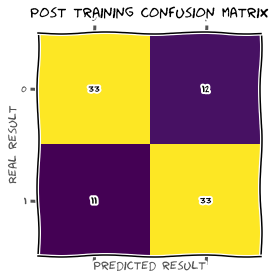

In [ ]:
#0 to 1, decimal point
print("Ranging from 0 to 1\n\n")
predicted_data = predicter.predict(x_test)
pr_double = predicted_data[:,0]
print(pr_double)

print('------------\n\n')


#0 or 1, rounded up if over .5
pr_binary = np.zeros(len(pr))
pr_binary[pr_double > 0.5] = 1
print("0 = non-diabetic, 1 = diabetic \n\n", pr_binary)

print("\n")
result_matrix = confusion_matrix(y_true=y_test, y_pred=pr_binary)
plot_matrix('Post training confusion matrix', result_matrix)

#KMean

If you get error running the box below, try to rerun the box containing "result_matrix". Unsure why it acts up at times, but rerunning the aforementioned box (a number of times might be neccesary) fixes the issue. 

Accuracy of prediction:  49.43820224719101


<Figure size 432x288 with 0 Axes>

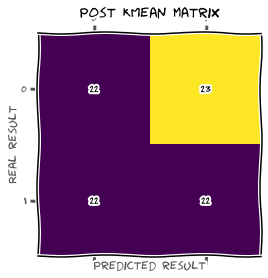

In [ ]:
#Fit and predict model
kmean_model = KMeans(n_clusters=2, random_state=42, algorithm="auto")
kmean_model.fit(x_train)
kmean_prediction = kmean_model.predict(x_test)

#Print and plot result
print("Accuracy of prediction: ", accuracy_score(y_test, kmean_prediction)*100)
kmean_cm = confusion_matrix(y_test, kmean_prediction)
result_matrix("Post KMean matrix", kmean_cm)

#Unsure as to why the colors are acting up.

#Logistic regression, sigmoid

If you get error running the box below, try to rerun the box containing "result_matrix". Unsure why it acts up at times, but rerunning the aforementioned box (a number of times might be neccesary) fixes the issue. 

Accuracy of prediction:  73.03370786516854


<Figure size 432x288 with 0 Axes>

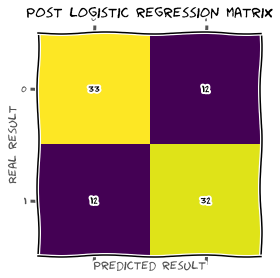

In [ ]:
#Fit and predict model
log_model = LogisticRegression(penalty='l2', random_state=0)
log_model.fit(x_train, y_train)
y_prediction = model.predict(x_test)

#Print and plot result
print("Accuracy of prediction: ", accuracy_score(y_test, y_prediction)*100)
log_cm = confusion_matrix(y_test, y_prediction)
result_matrix("Post logistic regression matrix", log_cm)